In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms


In [12]:
# ----------------------------
# 1️⃣ Dataset + Augmentation
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),         # Augmentation
    transforms.RandomRotation(20),            # Augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

dataset_path = '/content/drive/MyDrive/data/Garbage'
dataset = GarbageDataset(dataset_path, transform=transform)

# Split 80% train / 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Classes: {dataset.class_names}")


Found 2527 images across 6 classes
cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images
Number of training images: 2021
Number of test images: 506
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [13]:
# ----------------------------
# 2️⃣ Device
# ----------------------------
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
# ----------------------------
# 3️⃣ LeNetSequential (Bigger Model)
# ----------------------------
class LeNetSequential(nn.Module):
    def __init__(self, num_classes=6):
        super(LeNetSequential, self).__init__()

        # Conv layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # more filters
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        # FC layers
        self.classifier = nn.Sequential(
            nn.Linear(64*8*8, 256),   # adjust input size
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

num_classes = len(dataset.class_names)
model = LeNetSequential(num_classes=num_classes).to(device)
print(model)


LeNetSequential(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [15]:
# ----------------------------
# 4️⃣ Loss and optimizer
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# 5️⃣ Training loop with accuracy
# ----------------------------
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.2f}%")


Epoch [1/30] Loss: 1.6141 Accuracy: 33.10%
Epoch [2/30] Loss: 1.4030 Accuracy: 44.04%
Epoch [3/30] Loss: 1.3148 Accuracy: 48.79%
Epoch [4/30] Loss: 1.2124 Accuracy: 53.29%
Epoch [5/30] Loss: 1.1473 Accuracy: 56.41%
Epoch [6/30] Loss: 1.0930 Accuracy: 57.74%
Epoch [7/30] Loss: 1.0440 Accuracy: 60.02%
Epoch [8/30] Loss: 0.9986 Accuracy: 63.04%
Epoch [9/30] Loss: 0.9582 Accuracy: 63.68%
Epoch [10/30] Loss: 0.9066 Accuracy: 65.36%
Epoch [11/30] Loss: 0.8324 Accuracy: 68.73%
Epoch [12/30] Loss: 0.8245 Accuracy: 70.56%
Epoch [13/30] Loss: 0.7979 Accuracy: 70.36%
Epoch [14/30] Loss: 0.7573 Accuracy: 72.29%
Epoch [15/30] Loss: 0.7380 Accuracy: 73.87%
Epoch [16/30] Loss: 0.6826 Accuracy: 74.17%
Epoch [17/30] Loss: 0.6681 Accuracy: 75.41%
Epoch [18/30] Loss: 0.6243 Accuracy: 76.55%
Epoch [19/30] Loss: 0.6203 Accuracy: 76.69%
Epoch [20/30] Loss: 0.5692 Accuracy: 79.47%
Epoch [21/30] Loss: 0.5665 Accuracy: 78.97%
Epoch [22/30] Loss: 0.5436 Accuracy: 79.71%
Epoch [23/30] Loss: 0.5452 Accuracy: 79.3

In [16]:
# ----------------------------
# 6️⃣ Test evaluation
# ----------------------------
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 69.96%


In [23]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# ----------------------------
# 1️⃣ Define transform for test image
# ----------------------------
predict_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# ----------------------------
# 2️⃣ Prediction function
# ----------------------------
def predict_image(model, image_path, class_names):
    """
    Predict the class of a single image using the trained model.

    Args:
        model : trained LeNetSequential model
        image_path : path to image
        class_names : list of class names
    """
    model.eval()  # set model to evaluation mode

    # Load image
    image = Image.open(image_path).convert('RGB')

    # Apply transform
    input_tensor = predict_transform(image)
    input_tensor = input_tensor.unsqueeze(0)  # add batch dimension

    # Move to device
    input_tensor = input_tensor.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# ----------------------------
# 3️⃣ Example usage
# ----------------------------
image_path = '/content/drive/MyDrive/data/Garbage/trash/trash/trash1.jpg'  # replace with your image path
predicted_class = predict_image(model, image_path, dataset.class_names)
print(f"The predicted class is: {predicted_class}")


The predicted class is: trash


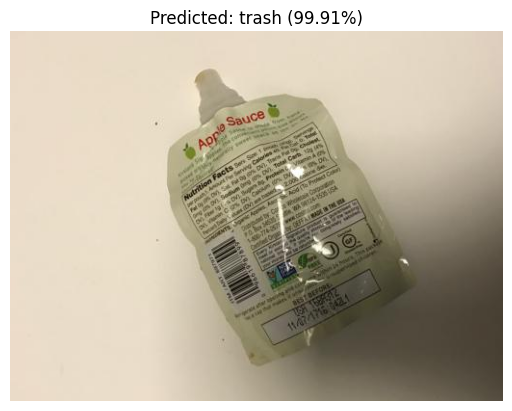

Predicted class: trash, Confidence: 99.91%


In [30]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------------------
# 1️⃣ Transform for prediction
# ----------------------------
predict_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# ----------------------------
# 2️⃣ Prediction function with visualization
# ----------------------------
def predict_and_show(model, image_path, class_names):
    """
    Predict the class of a single image and show it with predicted label and confidence.
    """
    model.eval()

    # Load image
    image = Image.open(image_path).convert('RGB')

    # Transform
    input_tensor = predict_transform(image)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)  # get probabilities
        confidence, predicted = torch.max(probs, 1)
        predicted_class = class_names[predicted.item()]

    # Show image with predicted label
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence.item()*100:.2f}%)")
    plt.show()

    # Return predicted class and confidence
    return predicted_class, confidence.item()

# ----------------------------
# 3️⃣ Example usage
# ----------------------------
image_path = '/content/drive/MyDrive/data/Garbage/trash/trash/trash1.jpg'  # replace with your image path
predicted_class, confidence = predict_and_show(model, image_path, dataset.class_names)
print(f"Predicted class: {predicted_class}, Confidence: {confidence*100:.2f}%")
